# Image Classification (Brain Tumor MRI)
![image](thumbnail.jpg)

# Packages

In [760]:
# Standard
import numpy as np
import pandas as pd

# Visualize
import matplotlib.pyplot as plt
import seaborn as sns

# Images
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

# Utility
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

# Neural network
import torch
import torch.nn as nn
from torch import optim

# Evaluation
from torchmetrics import Precision, Recall

# Transform for images

In [761]:
# Create transform for training
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(contrast=0.5),
    transforms.ToTensor()
])

# Create transform for testing
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128))
])

# Import training dataset

In [762]:
#Import training folder
train_data = ImageFolder(
    "data/training",
    transform = train_transform
)

#Create data loader
dataloader_train = DataLoader(
    train_data,
    batch_size = 32,
    shuffle = True
    )

#Make dataloader iterable
images, labels = next(iter(dataloader_train))

#Reshape image[0] tensor from batch
image = images[0].squeeze().permute(1, 2, 0)
image.size()

torch.Size([128, 128, 3])

# Save names for labels

In [763]:
# Names mapped to labels in dictionary
names = train_data.class_to_idx

# Keys from dictionary to list
keys = list(names.keys())

# Show batch

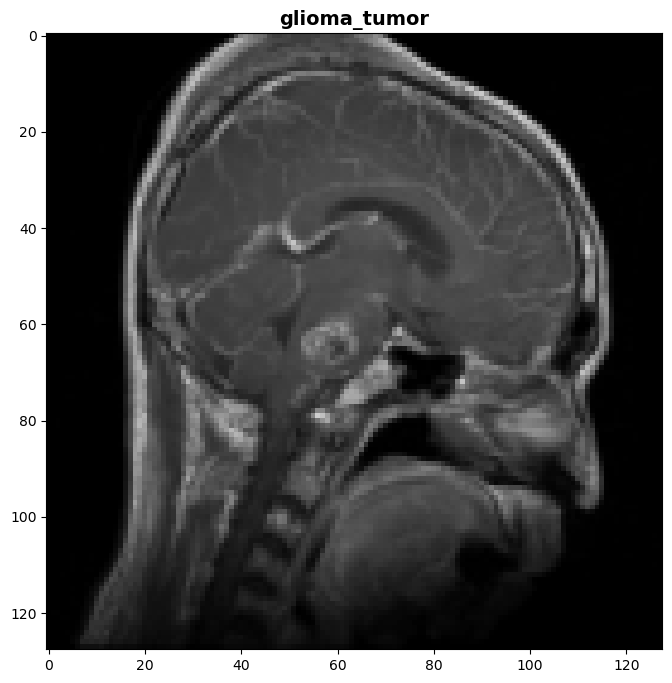

In [764]:
# Display images[0] from batch with matching labels[0] from batch
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title(keys[int(labels[0])], fontsize = 14, fontweight = "bold")
plt.show()

# Import testing dataset

In [765]:
#Import testing folder
test_data = ImageFolder(
    "data/testing",
    transform = test_transform
)

#Create data loader
dataloader_test = DataLoader(
    test_data,
    batch_size = 32,
    shuffle = True
    )

#Make dataloader iterable
test_images, test_labels = next(iter(dataloader_test))

# CNN

In [766]:
class Net(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        # Extract features
        self.extract = nn.Sequential(

            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(8),
            nn.ELU(),

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(),
            nn.Dropout(p = 0.2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten()
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(32 * 64 * 64, n_classes)
        )

    # Forward
    def forward(self, x):
        x = self.extract(x)
        x = self.classifier(x)
        return x

# Define model, loss function and optimizer

In [767]:
# Model
net = Net(n_classes=4)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(net.parameters(), lr = 0.0001, weight_decay=1e-4)

# Define metrics

In [768]:
# Defining metrics
metric_precision = Precision(task="multiclass", num_classes=4, average="weighted")
metric_recall = Recall(task="multiclass", num_classes=4, average="weighted")

# Training and evaluation loop

In [769]:
# Run n epochs
n_epochs = 20

# Train and test losses
train_losses = []
test_losses = []

# Run loop
for epoch in range(n_epochs):
    train_running_loss = 0.0
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()

    # Epoch train performance
    train_loss = train_running_loss / len(dataloader_train)
    train_losses.append(train_loss)
    
    # Evaluate model performance on test data
    net.eval()
    true_labels = []
    pred_labels = []
    test_running_loss = 0.0
    with torch.no_grad():
        for test_images, test_labels in dataloader_test:
            test_output = net(test_images)
            loss = criterion(test_output, test_labels)

            # Predictions
            _, pred = torch.max(test_output, 1)
            true_labels.extend(test_labels)
            pred_labels.extend(pred)

            # Metrics
            metric_precision(pred, test_labels)
            metric_recall(pred, test_labels)

            # Loss
            test_running_loss += loss.item()

    # Epoch train performance
    test_loss = test_running_loss / len(dataloader_test)
    test_losses.append(test_loss)

    # Compute metrics for test images
    precision = metric_precision.compute()
    recall = metric_recall.compute()

    # Print epoch results
    print(f'Epoch: {epoch + 1} | Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test precision: {precision:.4f} | Test recall: {recall:.4f}\n')

Epoch: 1 | Train loss: 1.1196 | Test loss: 2.2141 | Test precision: 0.5149 | Test recall: 0.4670

Epoch: 2 | Train loss: 0.6304 | Test loss: 2.2764 | Test precision: 0.5007 | Test recall: 0.4873

Epoch: 3 | Train loss: 0.4587 | Test loss: 2.3107 | Test precision: 0.5265 | Test recall: 0.5228

Epoch: 4 | Train loss: 0.3788 | Test loss: 2.5781 | Test precision: 0.5383 | Test recall: 0.5336

Epoch: 5 | Train loss: 0.3129 | Test loss: 2.3305 | Test precision: 0.5515 | Test recall: 0.5477

Epoch: 6 | Train loss: 0.2509 | Test loss: 2.4715 | Test precision: 0.5799 | Test recall: 0.5715

Epoch: 7 | Train loss: 0.2230 | Test loss: 3.3892 | Test precision: 0.5908 | Test recall: 0.5714

Epoch: 8 | Train loss: 0.1952 | Test loss: 2.7584 | Test precision: 0.6088 | Test recall: 0.5882

Epoch: 9 | Train loss: 0.1425 | Test loss: 2.6864 | Test precision: 0.6189 | Test recall: 0.5964

Epoch: 10 | Train loss: 0.1260 | Test loss: 2.9838 | Test precision: 0.6340 | Test recall: 0.6071

Epoch: 11 | Train l

# Save CNN

In [770]:
model = torch.save(net, "CNN_brain_mri_model.pth")

# Display train and test loss

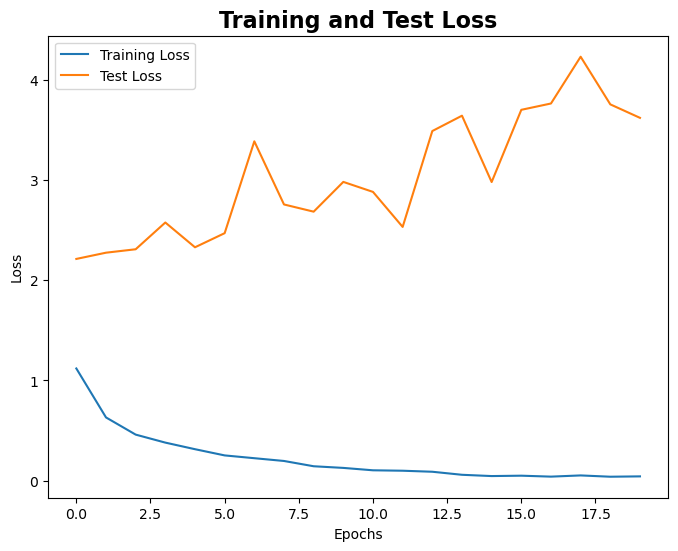

In [771]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss", fontweight = "bold", fontsize = 16)
plt.legend()
plt.show()

# Display confusion matrix from test data

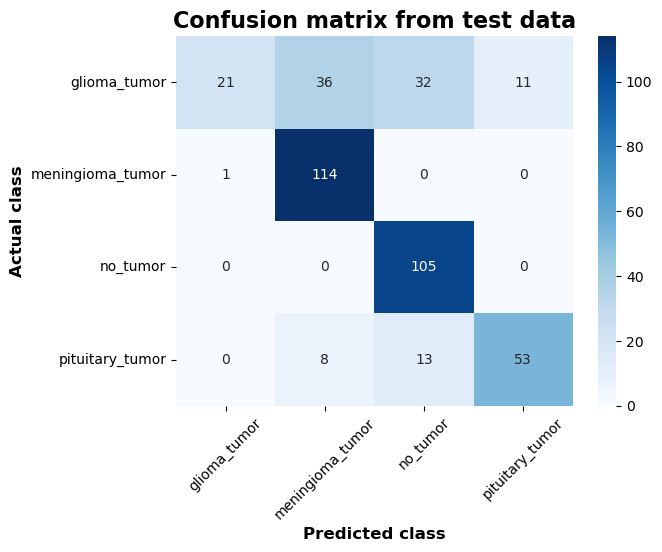

In [772]:
# Create confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Display confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="0.0f")
plt.title("Confusion matrix from test data", fontweight = "bold", fontsize = 16)
plt.xlabel("Predicted class", fontweight = "bold", fontsize = 12)
plt.ylabel("Actual class", fontweight = "bold", fontsize = 12)
plt.xticks(np.arange(4)+0.5, keys, rotation = 45)
plt.yticks(np.arange(4)+0.5, keys, rotation = 0)
plt.show()